In [1]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
import os
import time

# Load priors for SSD detection
loaded_priors = np.load('priors.npy')

# Initialize the detection ONNX model session
detection_session = ort.InferenceSession("SSD300 fp32.onnx")
detection_input_name = detection_session.get_inputs()[0].name
detection_output_names = [output.name for output in detection_session.get_outputs()]

# -------------------------------
# Helper Functions (Detection)
# -------------------------------

def read_img(path, W=300, H=300):
    """
    Read an image from disk, convert to RGB, resize and normalize.
    Note: For detection, we need the normalized version.
    """
    image = cv2.imread(path)
    if image is None:
        raise ValueError(f"Unable to load image at {path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (W, H))
    image = image / 255.0
    return image

def normalised_ground_truth(matched_boxes, feature_box, return_format):
    """
    Normalizes ground truth boxes based on anchor box dimensions.
    For 'encode', returns the encoded representation.
    For 'decode', converts encoded predictions back to box coordinates.
    """
    matched_boxes = matched_boxes.astype(np.float32)
    feature_box = feature_box.astype(np.float32)

    if return_format == "encode":
        x_offset = (matched_boxes[:, 0] - feature_box[:, 0]) / feature_box[:, 2]
        y_offset = (matched_boxes[:, 1] - feature_box[:, 1]) / feature_box[:, 3]
        w_scale = np.log(matched_boxes[:, 2] / feature_box[:, 2])
        h_scale = np.log(matched_boxes[:, 3] / feature_box[:, 3])
        encoded_boxes = np.stack([x_offset, y_offset, w_scale, h_scale], axis=-1)
        scale_factors = np.array([0.1, 0.1, 0.2, 0.2], dtype=np.float32)
        return encoded_boxes / scale_factors

    elif return_format == "decode":
        scale_factors = np.array([0.1, 0.1, 0.2, 0.2], dtype=np.float32)
        encoded_boxes = matched_boxes * scale_factors
        x_center = encoded_boxes[:, 0] * feature_box[:, 2] + feature_box[:, 0]
        y_center = encoded_boxes[:, 1] * feature_box[:, 3] + feature_box[:, 1]
        w = np.exp(encoded_boxes[:, 2]) * feature_box[:, 2]
        h = np.exp(encoded_boxes[:, 3]) * feature_box[:, 3]
        decoded_boxes = np.stack([x_center, y_center, w, h], axis=-1)
        return decoded_boxes

    else:
        raise ValueError("return_format must be either 'encode' or 'decode'")

In [2]:
def integrated_detection_label(image_path, priors,detection_session, detection_input_name, detection_output_names,show_box=True):
    """
    Combines object detection and label inference:
      1. Reads and preprocesses the image.
      2. Runs SSD detection using ONNX.
      3. Decodes the bounding boxes.
      4. Draws bounding boxes on the image.
      5. Displays the annotated image and returns the results.
    """
    # Read the original image (for cropping & display) and a normalized version for detection.
    orig_img = cv2.imread(image_path)
    if orig_img is None:
        raise ValueError(f"Unable to load image at {image_path}")
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    resized_img = cv2.resize(orig_img, (300, 300))  # This matches detection model input

    # Normalize image for detection inference
    img_norm = resized_img.astype(np.float32) / 255.0
    image_input = np.expand_dims(img_norm, axis=0)

    # Run detection model
    start_time = time.time()
    predictions = detection_session.run(detection_output_names, {detection_input_name: image_input})
    end_time = time.time()
    model_predictions = predictions[0]

    # Decode bounding boxes using the loaded priors
    boxes = normalised_ground_truth(model_predictions[0][:, :4], np.array(priors), 'decode')
    # Get confidence scores (assumed to be at index 4)
    classes = model_predictions[..., 4][0]
    
    # Select a subset of boxes based on score (your original logic)
    idx = np.argsort(classes)[:1]
    boxes = boxes[idx] * 300
    scores = 1 - np.sort(classes)[:1]

    # Convert from center-based boxes [x_center, y_center, w, h] to [xmin, ymin, xmax, ymax]
    xmin = boxes[:, 0] - boxes[:, 2] / 2
    ymin = boxes[:, 1] - boxes[:, 3] / 2
    xmax = boxes[:, 0] + boxes[:, 2] / 2
    ymax = boxes[:, 1] + boxes[:, 3] / 2
    fp = np.vstack((xmin, ymin, xmax, ymax)).T

    # Apply Non-Maximum Suppression (NMS)
    indices = cv2.dnn.NMSBoxes(
        bboxes=fp.tolist(),
        scores=scores.tolist(),
        score_threshold=0.0,
        nms_threshold=0.5,
        top_k=10
    )

    results = []
    image_display = resized_img.copy()

    if len(indices) > 0:
        indices = indices.flatten()
        for j in indices:
            x_min, y_min, x_max, y_max = map(int, fp[j])
            detection_score = scores[j]

            results.append({
                "bbox": [x_min, y_min, x_max, y_max],
                "score": float(detection_score),
                'infer_time': (end_time-start_time)*1000
            })

            # Draw the bounding box and label on the display image
            if show_box:
                cv2.rectangle(image_display, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

    plt.imshow(image_display)
    plt.axis('off')
    plt.show()

    return results

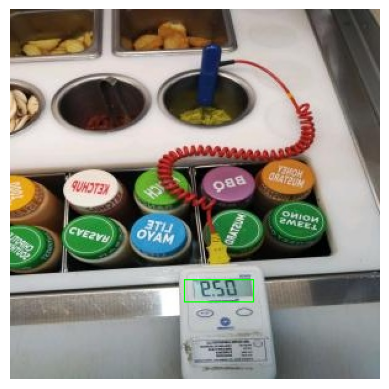


Image 1: horizontal_1001_jpg.rf.dfc0798279d416e17e5b66b7732b0d02.jpg
Integrated Detection and Label Results:
{'bbox': [141, 219, 197, 237], 'score': 0.9999970197677612, 'infer_time': 41.235923767089844}


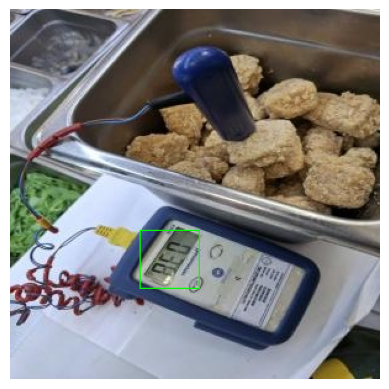


Image 2: horizontal_1003_jpg.rf.9e1dd0b2f20c2c4e8421872a1082338f.jpg
Integrated Detection and Label Results:
{'bbox': [105, 179, 153, 226], 'score': 0.9999439120292664, 'infer_time': 40.2979850769043}


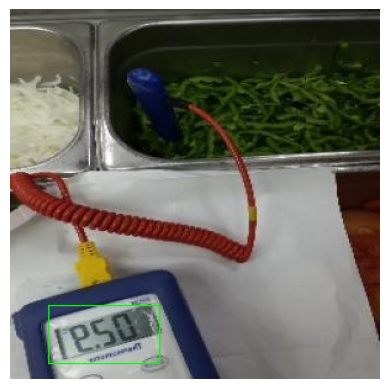


Image 3: horizontal_1005_jpg.rf.e88a16e43670ca75861b179ec860e972.jpg
Integrated Detection and Label Results:
{'bbox': [31, 240, 121, 287], 'score': 0.9999666810035706, 'infer_time': 36.32783889770508}


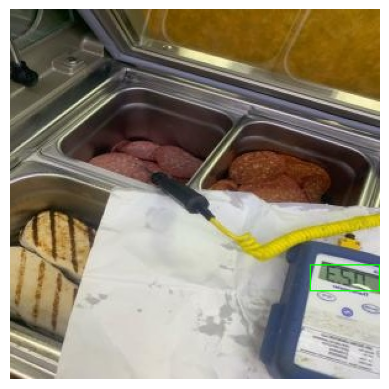


Image 4: horizontal_1006_jpg.rf.8b731fe600b0a5c719de06431df63b19.jpg
Integrated Detection and Label Results:
{'bbox': [243, 207, 299, 228], 'score': 0.99994957447052, 'infer_time': 39.49284553527832}


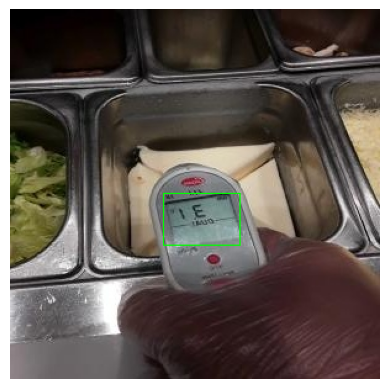


Image 5: horizontal_1007_jpg.rf.cf732530cfb0799276b06469abde91c5.jpg
Integrated Detection and Label Results:
{'bbox': [124, 149, 186, 191], 'score': 0.9986011981964111, 'infer_time': 47.95098304748535}


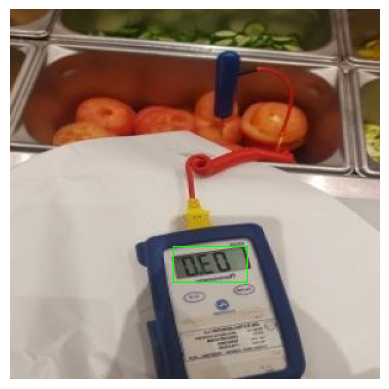


Image 6: horizontal_1008_jpg.rf.ad3ee5adcb45f86b8b2f3a02c20d831d.jpg
Integrated Detection and Label Results:
{'bbox': [132, 192, 192, 221], 'score': 0.6096806526184082, 'infer_time': 43.992042541503906}


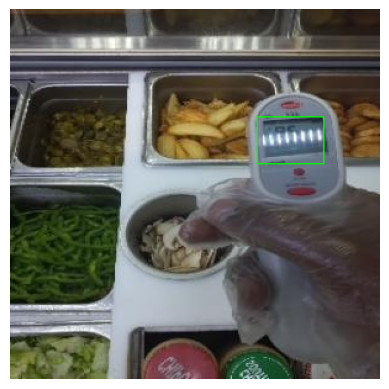


Image 7: horizontal_1009_jpg.rf.c4f556682d60a093f927ba41197858e6.jpg
Integrated Detection and Label Results:
{'bbox': [200, 87, 254, 125], 'score': 0.9958522319793701, 'infer_time': 43.18714141845703}


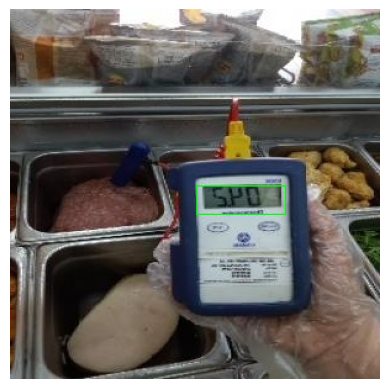


Image 8: horizontal_100_jpg.rf.f48a515f94f46665caf73a6574a1b570.jpg
Integrated Detection and Label Results:
{'bbox': [151, 143, 223, 166], 'score': 0.9967468976974487, 'infer_time': 48.45476150512695}


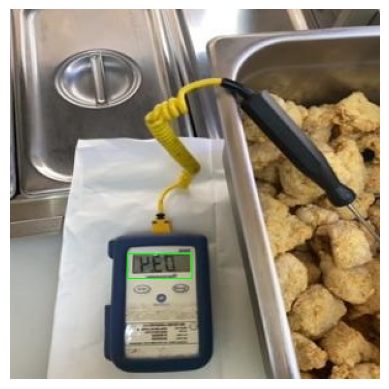


Image 9: horizontal_1010_jpg.rf.37efbc3650293b5e278b63d44ffef75c.jpg
Integrated Detection and Label Results:
{'bbox': [95, 198, 147, 218], 'score': 0.999970018863678, 'infer_time': 50.061941146850586}


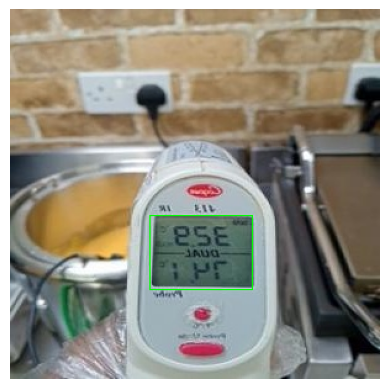


Image 10: horizontal_1011_jpg.rf.2e0fce0060be996634b1d2a2a3a0ebb9.jpg
Integrated Detection and Label Results:
{'bbox': [113, 167, 196, 227], 'score': 0.999924898147583, 'infer_time': 50.316810607910156}


In [3]:
# Folder path
image_folder = 'JPEGImages_flipped/'

# Get the first 10 image paths
image_paths = [os.path.join(image_folder, fname) for fname in sorted(os.listdir(image_folder)) 
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))][:10]

# Run detection on the first 10 images
for idx, image_path in enumerate(image_paths, start=1):
    results = integrated_detection_label(image_path, loaded_priors,
                                         detection_session, detection_input_name, detection_output_names)

    print(f"\nImage {idx}: {os.path.basename(image_path)}")
    print("Integrated Detection and Label Results:")
    for res in results:
        print(res)

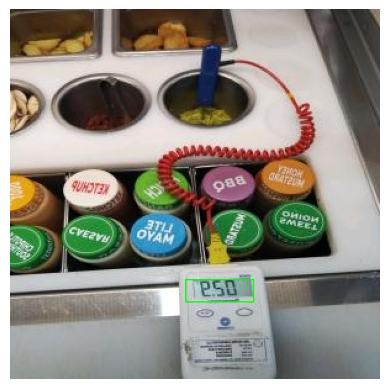


Image 1: horizontal_1001_jpg.rf.dfc0798279d416e17e5b66b7732b0d02.jpg
Integrated Detection and Label Results:
{'bbox': [142, 219, 197, 237], 'score': 1.0, 'infer_time': 11.410236358642578}


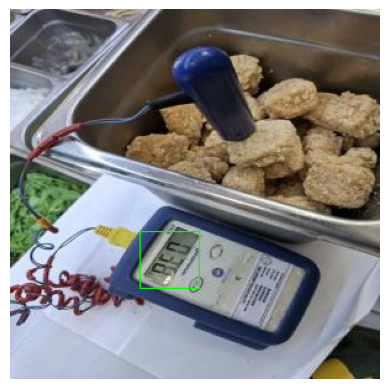


Image 2: horizontal_1003_jpg.rf.9e1dd0b2f20c2c4e8421872a1082338f.jpg
Integrated Detection and Label Results:
{'bbox': [105, 180, 153, 226], 'score': 1.0, 'infer_time': 15.582799911499023}


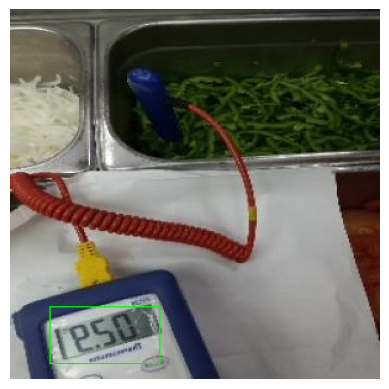


Image 3: horizontal_1005_jpg.rf.e88a16e43670ca75861b179ec860e972.jpg
Integrated Detection and Label Results:
{'bbox': [32, 241, 121, 287], 'score': 1.0, 'infer_time': 17.5018310546875}


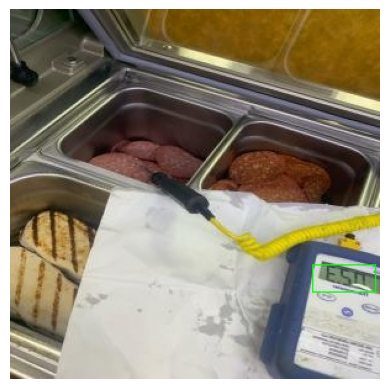


Image 4: horizontal_1006_jpg.rf.8b731fe600b0a5c719de06431df63b19.jpg
Integrated Detection and Label Results:
{'bbox': [245, 207, 296, 229], 'score': 1.0, 'infer_time': 17.628908157348633}


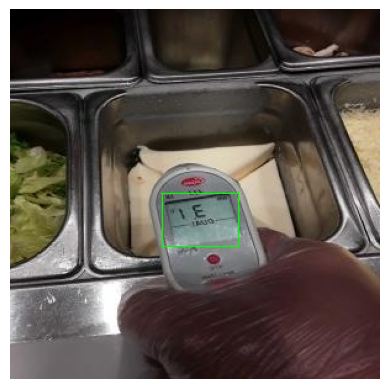


Image 5: horizontal_1007_jpg.rf.cf732530cfb0799276b06469abde91c5.jpg
Integrated Detection and Label Results:
{'bbox': [123, 149, 185, 192], 'score': 1.0, 'infer_time': 15.9149169921875}


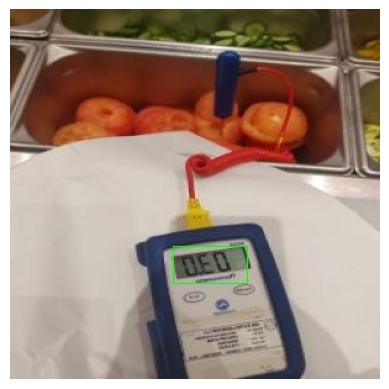


Image 6: horizontal_1008_jpg.rf.ad3ee5adcb45f86b8b2f3a02c20d831d.jpg
Integrated Detection and Label Results:
{'bbox': [132, 192, 192, 222], 'score': 0.6986952424049377, 'infer_time': 13.569116592407227}


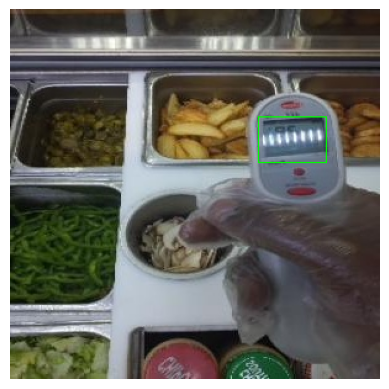


Image 7: horizontal_1009_jpg.rf.c4f556682d60a093f927ba41197858e6.jpg
Integrated Detection and Label Results:
{'bbox': [201, 87, 256, 124], 'score': 1.0, 'infer_time': 17.189979553222656}


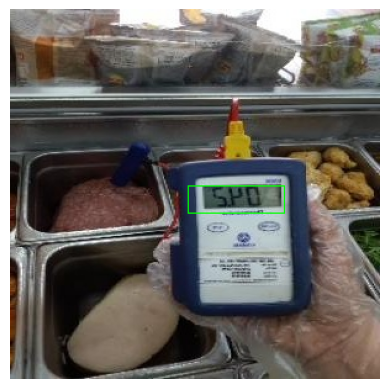


Image 8: horizontal_100_jpg.rf.f48a515f94f46665caf73a6574a1b570.jpg
Integrated Detection and Label Results:
{'bbox': [144, 143, 222, 165], 'score': 1.0, 'infer_time': 15.350818634033203}


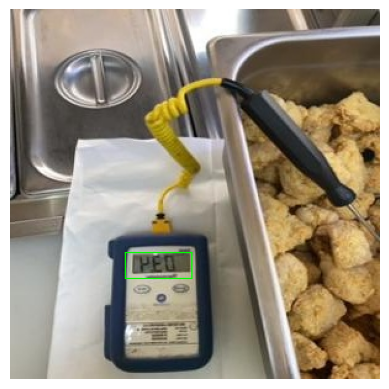


Image 9: horizontal_1010_jpg.rf.37efbc3650293b5e278b63d44ffef75c.jpg
Integrated Detection and Label Results:
{'bbox': [93, 197, 147, 218], 'score': 1.0, 'infer_time': 14.021158218383789}


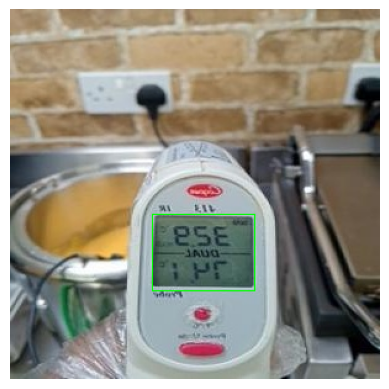


Image 10: horizontal_1011_jpg.rf.2e0fce0060be996634b1d2a2a3a0ebb9.jpg
Integrated Detection and Label Results:
{'bbox': [115, 166, 198, 228], 'score': 1.0, 'infer_time': 31.987905502319336}


In [4]:
# Load priors for SSD detection
loaded_priors = np.load('priors.npy')

# Initialize the detection ONNX model session
detection_session = ort.InferenceSession("SSD300 int8.onnx")
detection_input_name = detection_session.get_inputs()[0].name
detection_output_names = [output.name for output in detection_session.get_outputs()]

# Folder path
image_folder = 'JPEGImages_flipped/'

# Get the first 10 image paths
image_paths = [os.path.join(image_folder, fname) for fname in sorted(os.listdir(image_folder)) 
               if fname.lower().endswith(('.jpg', '.jpeg', '.png'))][:10]

# Run detection on the first 10 images
for idx, image_path in enumerate(image_paths, start=1):
    results = integrated_detection_label(image_path, loaded_priors,
                                         detection_session, detection_input_name, detection_output_names)

    print(f"\nImage {idx}: {os.path.basename(image_path)}")
    print("Integrated Detection and Label Results:")
    for res in results:
        print(res)